In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

2023-08-05 17:34:27.818617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 17:34:28.639384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#limit VRAM usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-08-05 17:34:29.463030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 17:34:29.585259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 17:34:29.585423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
#Load the dataset and create a dataframe with image paths and labels
dataset_path = "datasets/dataset1/data/"
images = []
labels = []
for folder in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, folder)):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if file.endswith(".jpg"):
                images.append(os.path.join(dataset_path, folder, file))
                labels.append(folder)
df = pd.DataFrame({"image": images, "label": labels})

In [4]:
#Load the validation set and create a dataframe with image paths and labels
validation_path = "datasets/dataset1/validation/"
images = []
labels = []
for folder in os.listdir(validation_path):
    if os.path.isdir(os.path.join(validation_path, folder)):
        for file in os.listdir(os.path.join(validation_path, folder)):
            if file.endswith(".jpg"):
                images.append(os.path.join(validation_path, folder, file))
                labels.append(folder)
vf = pd.DataFrame({"image": images, "label": labels})

In [5]:
#Define a function to preprocess the images: resize, grayscale, histogram equalization
def preprocess_image(image_path):
  image = cv2.imread(image_path)
  image = cv2.resize(image, (64, 64))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.equalizeHist(image)
  image = image / 255.0
  image = np.expand_dims(image, axis=2)
  return image

In [6]:
#Apply the preprocessing function to the images and convert the labels to numeric values
X_train = np.array([preprocess_image(image) for image in df["image"]])
y_train = np.array([0 if label == "male" else 1 for label in df["label"]])

X_test = np.array([preprocess_image(image) for image in vf["image"]])
y_test = np.array([0 if label == "male" else 1 for label in vf["label"]])

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

2023-08-05 17:34:52.337914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 17:34:52.338074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 17:34:52.338192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
#Compile and fit the model on the reweighted train set
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50


2023-08-05 17:34:56.191776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-05 17:34:57.391887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-05 17:34:57.429586: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f0c49a5c880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-05 17:34:57.429607: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-08-05 17:34:57.478373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-05 17:34:57.799898: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

1470/1470 [==============================] - 9s 3ms/step - loss: 0.2480 - accuracy: 0.8960 - val_loss: 0.1582 - val_accuracy: 0.9444
Epoch 2/50
1470/1470 [==============================] - 4s 3ms/step - loss: 0.1543 - accuracy: 0.9431 - val_loss: 0.1230 - val_accuracy: 0.9548
Epoch 3/50
1470/1470 [==============================] - 4s 3ms/step - loss: 0.1332 - accuracy: 0.9529 - val_loss: 0.1170 - val_accuracy: 0.9596
Epoch 4/50
1470/1470 [==============================] - 4s 3ms/step - loss: 0.1179 - accuracy: 0.9581 - val_loss: 0.1155 - val_accuracy: 0.9572
Epoch 5/50
1470/1470 [==============================] - 4s 3ms/step - loss: 0.1082 - accuracy: 0.9620 - val_loss: 0.1062 - val_accuracy: 0.9615
Epoch 6/50
1470/1470 [==============================] - 4s 3ms/step - loss: 0.0954 - accuracy: 0.9651 - val_loss: 0.1103 - val_accuracy: 0.9604
Epoch 7/50
1470/1470 [==============================] - 4s 3ms/step - loss: 0.0844 - accuracy: 0.9693 - val_loss: 0.1164 - val_accuracy: 0.9575
Epo

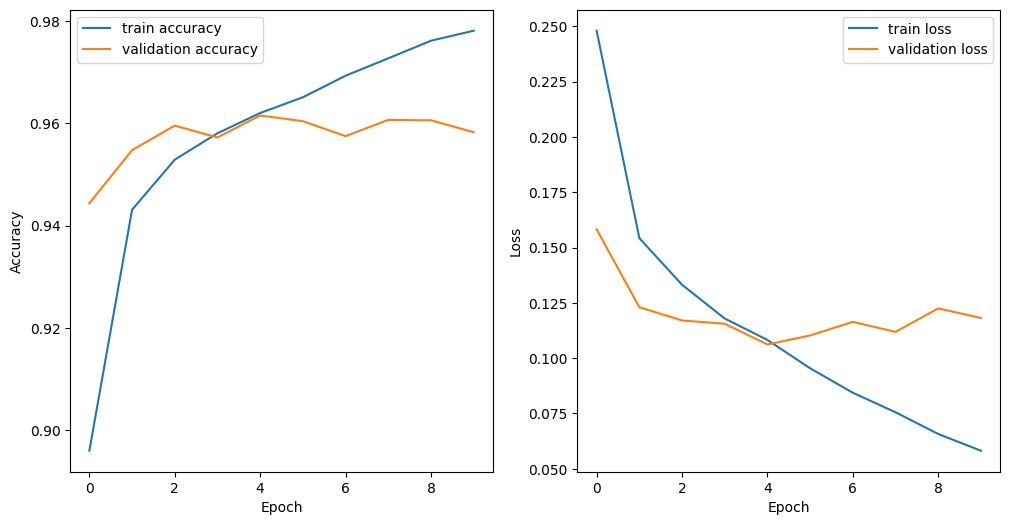

In [9]:
#Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
#Evaluate the model on the test set
y_pred = model.predict(X_test).round().ravel()
test_acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
test_cm = confusion_matrix(y_test, y_pred)
print("Test accuracy:", test_acc)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test confusion matrix:")
print(test_cm)

365/365 [==============================] - 0s 765us/step
Test accuracy: 0.958279680659284
Test Precision: 0.9560551865099642
Test Recall: 0.9609655880842322
Test confusion matrix:
[[5550  258]
 [ 228 5613]]
